In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium as fm
import numpy as np
from math import radians, cos, sin, asin, sqrt
from copy import deepcopy 
from scipy.stats import norm, kurtosis
import random

In [2]:
df = pd.read_csv('sites.csv') #read the data from the csv as a pandas dataframe
df['Random Demand'] = [400*np.random.rand() for x in df.index]
dists = np.load('dists.npy')
data = [df,dists]

def Fair(distribution, agegroups):
    #adapted the fairness formula to take into account that kids/adults/seniors
    #get different amounts of food by design
    allocations = {0:70, 1:56, 2:42} #0 is kids, 1 is adults, 2 is seniors. 
    if len(distribution) == 0:
        return 0
    
    totalsupply = sum(distribution)
    
    fairscore = 0
    for i in range(len(distribution)):
        recieved = distribution[i]/totalsupply
        allocated = allocations[agegroups[i]]/totalsupply
        fairscore += (recieved-allocated)**2
    
    fairscore = 1/(len(distribution)*fairscore+1)

    return fairscore

def returndata(data):
    df = data[0]
    dists = data[1]
    
    stdevs = np.array((df['StDev(Demand per Visit)']))
    variance = stdevs**2
    stdevs = np.sqrt(np.matmul(variance,dists))
    demands = np.array((df['Average Demand per Visit']))
    #demands = np.array((df['Random Demand']))
    increment = np.matmul(demands/(70/772*365), dists) 
    
    return demands, stdevs, increment

def runsite(site, data, RANDOM_DEMAND = True, SECOND_VISIT = False, FOOD = 0, LAST_VISIT = False):
    demands, stdevs, na = returndata(data) #gives the data we need    
    expdemand = demands[site] #expected demand for this site
    stdev = stdevs[site]      #standard deviation of demand at this site
    
    if RANDOM_DEMAND:
        demand = int(random.normalvariate(expdemand,stdev))#normally distributed random variable   
    else:
        demand = int(expdemand)
    
    daysoffood = 14 #how many days we expect the food to last everyone
    ages = np.array([.41,.4,.19]) #proportions of kids/adults/seniors
    fooddist = np.array([5,4,3]) #how many lbs of food kids/ad/sen eat each day
    evfood = np.dot(ages,fooddist*daysoffood) #expected value of food demanded by random person
    
    if SECOND_VISIT:
        LAST_VISIT = True
        totalfood = FOOD
    else:
        totalfood = min(15000,(expdemand+1.645*stdev)*evfood)
    #bring enough food so that you have >50 pounds per person 95% of the time
    
    ppl_food_quantity = []      # initialize array of X_i's for ppl's quanitity in lbs for 2 weeks
    agegroups = [] #age breakdown of crowd

    for i in range(0,demand):  # for each person at a site
        expleft = max(int(expdemand*(1-(i/demand))),1) #expected remaining people
        foodleft = totalfood-sum(ppl_food_quantity) #remaining food
        expfoodperperson = foodleft/expleft #expected remaining food/person
        
        ratio = 1 #default is don't change anything
        if LAST_VISIT: #if its the last visit of the day
            if expfoodperperson > evfood+10: #if we have a lot more food than we expect
                ratio = expfoodperperson/evfood #ratio>1                
        if expfoodperperson < evfood-10: #if we have a lot less food than we expect
            ratio = expfoodperperson/evfood #ratio < 1
        
        x = random.random()#random number to decide age of person
        if x<=ages[0]: #record their age group
                agegroups.append(0)
        elif x<=ages[0]+ages[1]:
            agegroups.append(1)
        else:
            agegroups.append(2)

        if sum(ppl_food_quantity)>totalfood: #if were out of food
            ppl_food_quantity.append(0) #you dont get any
        else:
            if x<=ages[0]:     # the person is a child
                ppl_food_quantity.append(min(100,max(35,fooddist[0]*daysoffood*ratio)))         # 5 lbs of food per day
                agegroups.append(0)
            elif x <= ages[0]+ages[1]:       # the person is an adult
                ppl_food_quantity.append(min(125,max(28,fooddist[1]*daysoffood*ratio)))         # 4lbs of food a day
                agegroups.append(1)
            else:                    # the person is a senior
                ppl_food_quantity.append(min(80,max(21,fooddist[2]*daysoffood*ratio)))       # 3lbs of food a day
                agegroups.append(2)
    # quantitative meansurement of fairness
    fairness_val = Fair(ppl_food_quantity, agegroups)

    if 0 not in ppl_food_quantity: #
        max_ppl_srvd = demand
    else:
        max_ppl_srvd = ppl_food_quantity.index(0)
        
    return fairness_val, max_ppl_srvd, sum(ppl_food_quantity)

In [3]:
#USE THIS CELL TO GENERATE THE SCHEDULES AND VALUES FOR THE PARETO FRONT
data = [df,dists]
demands,stdevs,increment = returndata(data)

schedules = [] 
demandDist = []
fairnesslevels = []

nvisits = np.zeros(70)

factorincrements = 50
maxfactor = 5
inc = maxfactor/factorincrements
factor = 0

while factor <= maxfactor:
    print(factor)
    schedule = [] #empty list for schedule
    demands = np.array((df['Average Demand per Visit']))
    daysElapsed = np.zeros(70)
    excessdemand = 0
    nsrvd = 0
    fairness = 0
    
    for day in range(365):
        
        fx = daysElapsed*factor
        demands = demands + fx

        a = deepcopy(demands)
        a = np.sort(a)

        first = a[-1]
        index1 = np.where(demands == first)
        second = a[-2]
        index2 = np.where(demands == second)

        demands = demands - fx
        
        fair1, maxsrvd1, pds1 = runsite(index1, data, RANDOM_DEMAND = False, LAST_VISIT = True)
        fair2, maxsrvd2, pds2 = runsite(index2, data, RANDOM_DEMAND = False, LAST_VISIT = True)
        
        fairness += fair1*maxsrvd1 + fair2*maxsrvd2
        nsrvd += maxsrvd1 + maxsrvd2
        
        demands = (demands - min(254,pds1/59.08)*dists[index1])[0]
        demands = (demands - min(254,pds1/59.08)*dists[index2])[0]
        
        daysElapsed = daysElapsed+1
        daysElapsed[int(index1[0])] = 0
        daysElapsed[int(index2[0])] = 0

        schedule.append([int(index1[0]),int(index2[0])])
        nvisits[index1] += 1
        nvisits[index2] += 1

        demands = [0 if x<0 else x for x in demands]
        demands = demands + increment
        excessdemand += sum(demands)

    schedules.append(schedule)
    fairnesslevels.append(float(fairness/nsrvd))
    demandDist.append(excessdemand/365)
    
    factor += inc

print(demandDist)
print(fairnesslevels)

0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7
0.7999999999999999
0.8999999999999999
0.9999999999999999
1.0999999999999999
1.2
1.3
1.4000000000000001
1.5000000000000002
1.6000000000000003
1.7000000000000004
1.8000000000000005
1.9000000000000006
2.0000000000000004
2.1000000000000005
2.2000000000000006
2.3000000000000007
2.400000000000001
2.500000000000001
2.600000000000001
2.700000000000001
2.800000000000001
2.9000000000000012
3.0000000000000013
3.1000000000000014
3.2000000000000015
3.3000000000000016
3.4000000000000017
3.5000000000000018
3.600000000000002
3.700000000000002
3.800000000000002
3.900000000000002
4.000000000000002
4.100000000000001
4.200000000000001
4.300000000000001
4.4
4.5
4.6
4.699999999999999
4.799999999999999
4.899999999999999
4.999999999999998
[4042.4574979958934, 3992.478480546588, 3920.329178069752, 3950.0902883374138, 3915.4157158912894, 3825.2342835400705, 3890.7460528753913, 3821.4078345903054, 3865.3557242932543, 3824.8591174288167, 3802.7296838749144, 3883.10880

In [4]:
freqList = []
for level in schedules:
    freq = [0] * 70
    for day in level:
        freq[day[0]] += 1
        freq[day[1]] += 1
    freqList.append(freq)

In [5]:
def gini(list):
    ## first sort
    arr = np.array(list)
    sorted_arr = arr.copy()
    sorted_arr.sort()
    n = arr.size
    coef_ = 2. / n
    const_ = (n + 1.) / n
    weighted_sum = sum([(i+1)*yi for i, yi in enumerate(sorted_arr)])
    return coef_*weighted_sum/(sorted_arr.sum()) - const_

def identify_pareto(scores):
    # Count number of items
    population_size = scores.shape[0]
    # Create a NumPy index for scores on the pareto front (zero indexed)
    population_ids = np.arange(population_size)
    # Create a starting list of items on the Pareto front
    # All items start off as being labelled as on the Parteo front
    pareto_front = np.ones(population_size, dtype=bool)
    # Loop through each item. This will then be compared with all other items
    for i in range(population_size):
        # Loop through all other items
        for j in range(population_size):
            # Check if our 'i' pint is dominated by our 'j' point
            if all(scores[j] < scores[i]) and any(scores[j] <= scores[i]):
                # j dominates i. Label 'i' point as not on Pareto front
                pareto_front[i] = 0
                # Stop further comparisons with 'i' (no more comparisons needed)
                break
    # Return ids of scenarios on pareto front
    return population_ids[pareto_front]

def lorenz_curve(freq):
    X = np.array(freq)
    X_lorenz = X.cumsum() / X.sum()
    X_lorenz = np.insert(X_lorenz, 0, 0) 
    X_lorenz[0], X_lorenz[-1]
    fig, ax = plt.subplots(figsize=[6,6])
    ## scatter plot of Lorenz curve
    ax.scatter(np.arange(X_lorenz.size)/(X_lorenz.size-1), X_lorenz, 
               marker='x', color='darkgreen', s=100)
    ## line plot of equality
    ax.plot([0,1], [0,1], color='k')

In [6]:
freqList[0].sort()

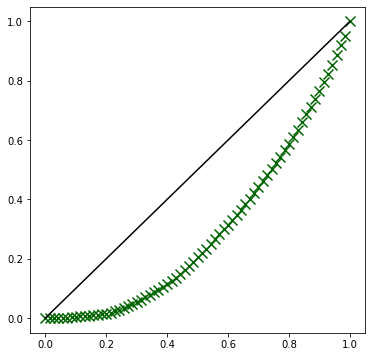

In [7]:
lorenz_curve(freqList[0])

In [8]:
unfairness = [1 - i for i in fairnesslevels] #minimize unfairness = maximize fairness
giniList = []
for i in freqList:
    giniList.append(gini(i))
minimize = np.column_stack((demandDist, giniList, unfairness))

<IPython.core.display.Javascript object>


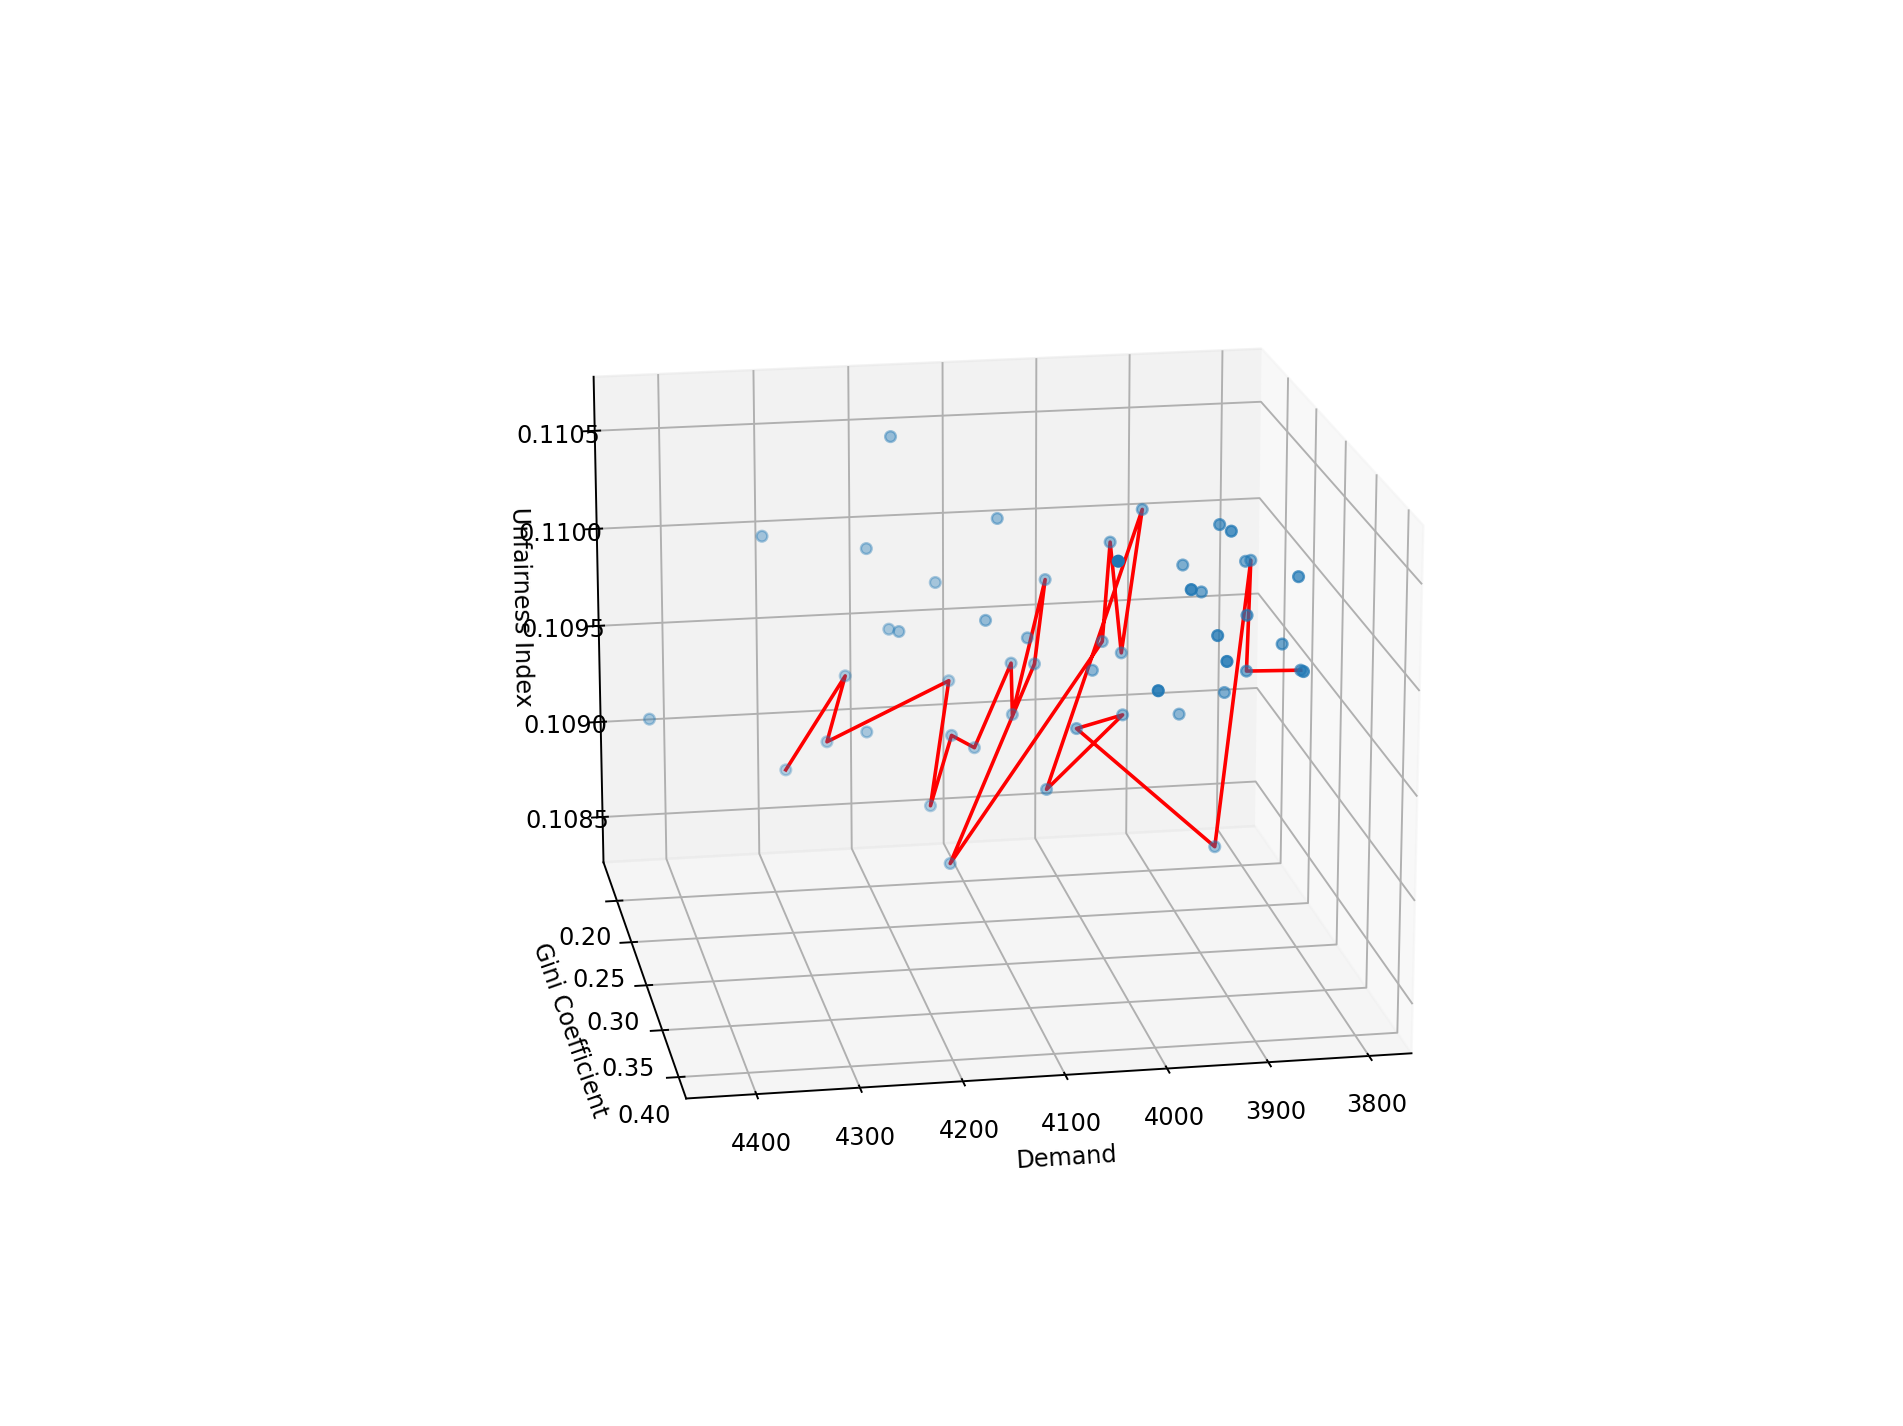

In [9]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
pareto = identify_pareto(minimize)
pareto_front = minimize[pareto]
x_all = minimize[:, 0]
y_all = minimize[:, 1]
z_all = minimize[:, 2]
x_pareto = pareto_front[:, 0]
y_pareto = pareto_front[:, 1]
z_pareto = pareto_front[:, 2]


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_all, y_all, z_all)
ax.plot(x_pareto, y_pareto, z_pareto, color='r')
ax.set_xlabel('Demand')
ax.set_ylabel('Gini Coefficient')
ax.set_zlabel('Unfairness Index')
plt.show()

In [10]:
#RUN THIS CELL TO GENERATE THE BEST SCHEDULE
unfairness = 1 - np.array(fairnesslevels)

scaleddemand = (demandDist-min(demandDist))/(max(demandDist)-min(demandDist))
scaledfairness = (max(unfairness) - unfairness)/(max(unfairness)-min(unfairness))
scaledgini = (giniList-min(giniList))/(max(giniList)-min(giniList))

weightedarray = .5*scaleddemand+.3*scaledfairness+.2*scaledgini
ideal = np.where(weightedarray == min(weightedarray))[0][0]
idealfactor = ideal*inc

bestschedule = schedules[ideal]
#print(bestschedule) #our proposed 365 day schedule
totaldemand = demandDist[ideal]
ourfairness = fairnesslevels[ideal]
ginicoeff = giniList[ideal]

print(totaldemand,ourfairness,ginicoeff)

3834.394026588036 0.889903131434295 0.268375733855186


In [28]:
def testschedule(schedule):
    
    demands, stdevs, increment = returndata(data)
    ntrials = 2
    
    avgfairness = np.zeros(ntrials)
    avgdemand = np.zeros(ntrials)
    ginicoeff = np.zeros(ntrials)
    totalfood = np.zeros(ntrials)
    for i in range(ntrials):
        nsrvd = 0
        fairness = 0
        excessdemand = 0
        totallbs = 0
        nvisits = np.zeros(70)
        for day in schedule:    
            site1 = day[0]
            site2 = day[1]
            
            fair1, nsrvd1, lbs1 = runsite(site1, data, LAST_VISIT = True)
            fair2, nsrvd2, lbs2 = runsite(site2, data, LAST_VISIT = True)            
            
            fairness += fair1*nsrvd1 + fair2*nsrvd2
            nsrvd += nsrvd1 + nsrvd2
            
            demands = (demands - min(254, lbs1/59.08)*dists[site1])
            demands = (demands - min(254, lbs2/59.08)*dists[site2])
            
            print('first stops')
            print(sum(demands))
            
            #print(demands)
            nvisits[site1] += 1
            nvisits[site2] += 1
        
            demands = [0 if x<0 else x for x in demands]
            demands = demands + increment
            excessdemand += sum(demands)
            totallbs += lbs1+lbs2
            
        nvisits.sort()
        
        avgdemand[i] = excessdemand/365
        avgfairness[i] = fairness/nsrvd
        ginicoeff[i] = gini(nvisits)
        totalfood[i] = totallbs
    
    Average_Demand = np.mean(avgdemand)
    Average_Fairness = np.mean(avgfairness)
    Total_Food = np.mean(totallbs)
    Gini_Coefficient = gini(nvisits)

    print('Average Demand: ', Average_Demand)
    print('Average Fairness: ', Average_Fairness)
    print('Gini Coefficient: ', Gini_Coefficient)
    print('Total Food Distributed: ', Total_Food)
    
    return [Average_Demand, Average_Fairness, Gini_Coefficient, Total_Food]

def testschedule2(schedule):
    
    demands, stdevs, increment = returndata(data)
    ntrials = 2
    
    avgfairness = np.zeros(ntrials)
    avgdemand = np.zeros(ntrials)
    ginicoeff = np.zeros(ntrials)
    totalfood = np.zeros(ntrials)
    for i in range(ntrials):
        nsrvd = 0
        fairness = 0
        excessdemand = 0
        totallbs = 0
        nvisits = np.zeros(70)
        for day in schedule:    
            site1 = day[0][0]
            site12 = day[0][1]
            site2 = day[1][0]
            site22 = day[1][1]
            
            fair1, nsrvd1, lbs1 = runsite(site1, data, LAST_VISIT = False)
            fair2, nsrvd2, lbs2 = runsite(site2, data, LAST_VISIT = False)            
            
            fairness += fair1*nsrvd1 + fair2*nsrvd2
            nsrvd += nsrvd1 + nsrvd2
            
            demands = (demands - min(254, lbs1/59.08)*dists[site1])
            demands = (demands - min(254, lbs2/59.08)*dists[site2])
            print('first stops')
            print(sum(demands))
            
            #print(demands)
            nvisits[site1] += 1
            nvisits[site2] += 1
            
            if site12 != -1:
                fair12, nsrvd12, lbs12 = runsite(site12, data, LAST_VISIT = True)
                fairness += fair12*nsrvd12
                nsrvd += nsrvd12
                demands = (demands - min(254 - nsrvd1, lbs12/59.08)*dists[site12])
                nvisits[site12] += 1
                totallbs += lbs12
                print('hit12')
                print(sum(demands))
            
            if site22 != -1:
                fair22, nsrvd22, lbs22 = runsite(site22, data, LAST_VISIT = True)
                fairness += fair22*nsrvd22
                nsrvd += nsrvd22
                demands = (demands - min(254 - nsrvd2, lbs22/59.08)*dists[site22])
                nvisits[site22] += 1
                totallbs += lbs22
                print('hit22')
                print(sum(demands))
                 
        
            demands = [0 if x < 0 else x for x in demands]
            demands = demands + increment
            excessdemand += sum(demands)
            totallbs += lbs1+lbs2
            
        nvisits.sort()
        
        avgdemand[i] = excessdemand/365
        avgfairness[i] = fairness/nsrvd
        ginicoeff[i] = gini(nvisits)
        totalfood[i] = totallbs
    
    Average_Demand = np.mean(avgdemand)
    Average_Fairness = np.mean(avgfairness)
    Total_Food = np.mean(totallbs)
    Gini_Coefficient = gini(nvisits)

    print('Average Demand: ', Average_Demand)
    print('Average Fairness: ', Average_Fairness)
    print('Gini Coefficient: ', Gini_Coefficient)
    print('Total Food Distributed: ', Total_Food)
    
    return [Average_Demand, Average_Fairness, Gini_Coefficient, Total_Food]

In [12]:
def con_max(priorities, demand, leftover):
    index = -1
    for i in range(len(priorities)):
        if priorities[i] > priorities[index] and demand[i] <= leftover:
            index = i
    return index

In [13]:
def locate_min(a):
    smallest = min(a) #returns indices of all elements in list equal to the minimum element
    return [index for index, element in enumerate(a) if smallest == element]  
def locate_max(a):
    biggest = max(a)
    return [index for index, element in enumerate(a) if biggest == element]

In [14]:
countList = []
for year in schedules:
    freq = [0] * 70
    for day in year:
        freq[day[0]] += 1
        freq[day[1]] += 1
    countList.append(freq)
    
nSchedule = []
na, stdevs, na = returndata([df,dists])
avgDemands = df['Average Demand per Visit']

for day in schedules[ideal]: #run the best schedule block to get ideal
    daily = []
    for site in day:
        totalfood = min(15000, (avgDemands[site] + 1.645*stdevs[site])*59.08)
        leftover = (totalfood - (avgDemands[site]*59.08))

        if leftover >= (min(avgDemands)+1.645*stdevs[list(avgDemands).index(min(avgDemands))])*59.08: #95% threshold
            rare = locate_min(countList[ideal])
            rare_demand = []
            
            for i in rare:
                rare_demand.append(avgDemands[i])
            second = locate_max(rare_demand)
            visit = avgDemands[avgDemands == rare_demand[second[0]]]

            index = int(visit.index.tolist()[0])
            daily.append([site, index])
            countList[ideal][index] += 1
        
        else:
            daily.append([site, -1])
    nSchedule.append(daily)
nSchedule

[[[65, -1], [1, -1]],
 [[16, -1], [2, -1]],
 [[27, -1], [31, -1]],
 [[61, -1], [12, -1]],
 [[10, -1], [29, -1]],
 [[21, -1], [30, -1]],
 [[5, -1], [28, -1]],
 [[4, -1], [65, -1]],
 [[0, 60], [64, -1]],
 [[67, 37], [68, 35]],
 [[63, 44], [9, 55]],
 [[33, 49], [1, -1]],
 [[20, -1], [25, 38]],
 [[69, 48], [17, 45]],
 [[8, 54], [3, 59]],
 [[7, 60], [32, 50]],
 [[13, -1], [22, 58]],
 [[18, -1], [14, 40]],
 [[23, 47], [66, -1]],
 [[16, -1], [31, -1]],
 [[34, -1], [11, 37]],
 [[2, -1], [27, -1]],
 [[19, 35], [12, -1]],
 [[15, 44], [62, 55]],
 [[65, -1], [61, -1]],
 [[26, 49], [30, -1]],
 [[10, -1], [24, -1]],
 [[39, -1], [21, -1]],
 [[6, 38], [29, -1]],
 [[1, -1], [28, -1]],
 [[64, -1], [9, 48]],
 [[68, 45], [5, -1]],
 [[4, -1], [67, 54]],
 [[42, -1], [66, -1]],
 [[0, 59], [41, 60]],
 [[63, 46], [56, -1]],
 [[36, -1], [57, -1]],
 [[20, -1], [25, 53]],
 [[22, 43], [8, 50]],
 [[65, -1], [31, -1]],
 [[33, 58], [16, -1]],
 [[12, -1], [52, -1]],
 [[69, 40], [14, 47]],
 [[13, -1], [2, -1]],
 [[46, 

In [15]:
foodMap = fm.Map(location=[42.3, -76.5], tiles='Stamen Toner', zoom_start = 9.2)
coordinates = df[['latitude', 'longitude']]
coordinateList = coordinates.values.tolist()
#print(coordinateList)
for element in coordinateList:
    fm.CircleMarker(element, radius=3, color='blue', opacity=0.3).add_to(foodMap)
foodMap

In [16]:
final = []
for i in nSchedule:
    daily = []
    for j in i:
        truck = []
        for k in j:
            if k == -1:
                truck.append('None')
            else:
                truck.append(df.at[k,'Site Name'])
        daily.append(truck)
    final.append(daily)

In [17]:
for i in final:
    print(i[1][0])

MFP Avoca
MFP Bath
MFP Richford
MFP College TC3 -College
MFP Redeemer Lutheran Church
MFP Rehoboth Deliverance Ministry
MFP Reach for Christ Church Freeville
MFP Waverly
MFP Van Etten
MFP Windsor
MFP Colesville
MFP Avoca
MFP Owego VFW
MFP Erin
MFP Beaver Dams
MFP Saint Mary Recreation Center
MFP Millport
MFP Danby
MFP Wayland
MFP Richford
MFP College Ithaca College
MFP Rathbone
MFP College TC3 -College
MFP Troupsburg
MFP The Love Church
MFP Rehoboth Deliverance Ministry
MFP Nichols-The Creamery
MFP Lindley
MFP Redeemer Lutheran Church
MFP Reach for Christ Church Freeville
MFP Colesville
MFP Boys and Girls Club
MFP Whitney Point
MFP Wayland
MFP Senior - Corning Senior Center
MFP Senior - Titus Towers
MFP Senior - Villa Serene
MFP Owego VFW
MFP Canisteo
MFP Richford
MFP Endwell United Methodist Church
MFP Senior - North Shore Towers
MFP Danby
MFP Bath
MFP Senior - Metro Plaza Apartments
MFP Rathbone
MFP Deposit
MFP The Love Church
MFP First Assembly Of God Church
MFP Saint Mary Recreatio

In [29]:
testschedule(schedules[ideal])

first stops
9392.137943567097
first stops
9183.838824942799
first stops
8974.970070307016
first stops
8772.924687606275
first stops
8564.055803066163
first stops
8366.159500893391
first stops
8201.538961076998
first stops
7992.670076536879
first stops
7794.114441341266
first stops
7606.019521750257
first stops
7443.835425200562
first stops
7235.593024151889
first stops
7120.620033499883
first stops
6948.895444002318
first stops
6776.217160455324
first stops
6671.9717333512235
first stops
6612.219955836846
first stops
6500.832727048514
first stops
6578.999368338216
first stops
6370.773977055822
first stops
6338.951395699566
first stops
6130.267445119291
first stops
5982.220759834911
first stops
5858.877131820521
first stops
5674.572396642369
first stops
5602.129130236652
first stops
5479.197135727877
first stops
5410.439812891713
first stops
5317.641239177878
first stops
5193.1091276806565
first stops
5020.817277866771
first stops
4813.352607802692
first stops
4677.201480939381
first st

first stops
3923.4728655452
first stops
4023.8064782242272
first stops
3863.3610618612615
first stops
3910.726550886267
first stops
3938.001747187323
first stops
3905.977936477469
first stops
3923.3666707905377
first stops
4117.1277260572015
first stops
3913.2050749773603
first stops
3775.8808607202473
first stops
4064.508437001387
first stops
3883.080838876876
first stops
4098.162568753555
first stops
4176.490540012908
first stops
4069.5689464352536
first stops
3973.50758462625
first stops
3991.060139046737
first stops
4108.74671991757
first stops
4057.45387304082
first stops
4279.1784074897105
first stops
4146.32396464472
first stops
4161.64085843719
first stops
4177.410755874978
first stops
4253.31951997845
first stops
4247.932120174281
first stops
4370.762499990203
first stops
4287.967242381495
first stops
4455.197605436169
first stops
4343.357401621533
first stops
4163.736875444504
first stops
4111.721206407206
first stops
4097.540842672336
first stops
4105.0402173729035
first sto

first stops
3694.5397480649194
first stops
3721.627376184689
first stops
3659.701030079871
first stops
3655.937627655966
first stops
4012.6657930651872
first stops
3887.8497733732142
first stops
3888.7089314020527
first stops
3986.1111688551073
first stops
3842.598837442397
first stops
3929.4239692744477
first stops
4062.7645122690337
first stops
4047.973571471117
first stops
4059.8151574369053
first stops
4076.500042138992
first stops
4082.3497311632564
first stops
4019.2328593644033
first stops
3966.352886212153
first stops
3845.061926069195
first stops
3927.889886021818
first stops
3747.837286942987
first stops
3832.271742556482
first stops
3756.8751849467917
first stops
3867.5370726757233
first stops
3960.0820098054874
first stops
3833.626891163687
first stops
3911.7641597082747
first stops
3765.291763099071
first stops
4091.8660286540394
first stops
3971.0474107703144
first stops
3898.0944977137856
first stops
3985.660554089322
first stops
3942.195627875468
first stops
3897.606659

[4525.164153969821, 0.8595554988134573, 0.268375733855186, 8641716.682882138]

In [ ]:
testschedule2(nSchedule)

first stops
9391.999999999998
first stops
9183.522777407985
first stops
9010.852945000575
first stops
8802.120006003342
first stops
8656.4643916054
first stops
8506.30640753922
first stops
8297.518202355332
first stops
8119.9541015779105
first stops
7931.9098615875555
hit12
7959.909861587554
first stops
7850.582886233495
hit12
7836.874327185251
hit22
7799.3535363463025
first stops
7734.9775428014445
hit12
7679.829825086701
hit22
7679.829825086701
first stops
7572.370748127254
hit12
7516.064607317597
first stops
7526.89499880616
hit22
7466.714242399219
first stops
7332.507727545765
hit12
7341.507727545767
hit22
7297.507727545766
first stops
7231.757252594337
hit12
7185.548721788651
hit22
7137.224415762924
first stops
7221.348071535425
hit12
7221.348071535425
hit22
7155.098216906167
first stops
7115.785058085219
hit22
7084.78505808522
first stops
7070.822209981106
hit22
7039.170212689298
first stops
7008.6804750686115
hit12
6998.668661780333
first stops
6789.799777240216
first stops
6842

first stops
4516.337543473163
first stops
4629.238866249132
first stops
4548.2611182641385
first stops
4661.345757963125
hit12
4621.992338870367
hit22
4566.992338870367
first stops
4568.489719496943
hit12
4531.48971949694
first stops
4473.777233061087
first stops
4495.754070605821
first stops
4454.3047268921455
hit12
4444.3047268921455
hit22
4330.304726892146
first stops
4206.532412351408
first stops
4124.250383454176
hit22
4056.250383454175
first stops
4218.891363596883
hit12
4056.891363596882
first stops
4093.017739720272
hit22
4106.0177397202715
first stops
4071.647234491674
first stops
4153.376988553467
first stops
4086.9359843125285
hit12
4112.9359843125285
hit22
4029.935984312528
first stops
4050.422501790569
hit22
3957.4225017905687
first stops
4363.027552199173
first stops
4262.528243691339
hit22
4158.52824369134
first stops
4301.326223659846
first stops
4395.326102421474
first stops
4305.959997490295
first stops
4391.293439320761
first stops
4640.659920990149
hit12
4538.827162

In [22]:
schedules[ideal]

[[65, 1],
 [16, 2],
 [27, 31],
 [61, 12],
 [10, 29],
 [21, 30],
 [5, 28],
 [4, 65],
 [0, 64],
 [67, 68],
 [63, 9],
 [33, 1],
 [20, 25],
 [69, 17],
 [8, 3],
 [7, 32],
 [13, 22],
 [18, 14],
 [23, 66],
 [16, 31],
 [34, 11],
 [2, 27],
 [19, 12],
 [15, 62],
 [65, 61],
 [26, 30],
 [10, 24],
 [39, 21],
 [6, 29],
 [1, 28],
 [64, 9],
 [68, 5],
 [4, 67],
 [42, 66],
 [0, 41],
 [63, 56],
 [36, 57],
 [20, 25],
 [22, 8],
 [65, 31],
 [33, 16],
 [12, 52],
 [69, 14],
 [13, 2],
 [46, 51],
 [7, 27],
 [17, 15],
 [3, 61],
 [21, 18],
 [30, 32],
 [10, 29],
 [34, 11],
 [62, 1],
 [53, 66],
 [5, 65],
 [23, 26],
 [43, 28],
 [4, 0],
 [19, 67],
 [16, 39],
 [6, 47],
 [64, 50],
 [9, 68],
 [2, 58],
 [20, 40],
 [12, 63],
 [33, 25],
 [61, 37],
 [65, 31],
 [27, 66],
 [29, 49],
 [28, 10],
 [24, 44],
 [22, 13],
 [1, 55],
 [21, 15],
 [8, 35],
 [5, 14],
 [18, 32],
 [69, 30],
 [16, 59],
 [17, 7],
 [0, 4],
 [65, 42],
 [3, 38],
 [2, 11],
 [34, 48],
 [67, 41],
 [57, 45],
 [36, 61],
 [56, 54],
 [12, 29],
 [23, 62],
 [33, 20],
 [

In [23]:
nSchedule

[[[65, -1], [1, -1]],
 [[16, -1], [2, -1]],
 [[27, -1], [31, -1]],
 [[61, -1], [12, -1]],
 [[10, -1], [29, -1]],
 [[21, -1], [30, -1]],
 [[5, -1], [28, -1]],
 [[4, -1], [65, -1]],
 [[0, 60], [64, -1]],
 [[67, 37], [68, 35]],
 [[63, 44], [9, 55]],
 [[33, 49], [1, -1]],
 [[20, -1], [25, 38]],
 [[69, 48], [17, 45]],
 [[8, 54], [3, 59]],
 [[7, 60], [32, 50]],
 [[13, -1], [22, 58]],
 [[18, -1], [14, 40]],
 [[23, 47], [66, -1]],
 [[16, -1], [31, -1]],
 [[34, -1], [11, 37]],
 [[2, -1], [27, -1]],
 [[19, 35], [12, -1]],
 [[15, 44], [62, 55]],
 [[65, -1], [61, -1]],
 [[26, 49], [30, -1]],
 [[10, -1], [24, -1]],
 [[39, -1], [21, -1]],
 [[6, 38], [29, -1]],
 [[1, -1], [28, -1]],
 [[64, -1], [9, 48]],
 [[68, 45], [5, -1]],
 [[4, -1], [67, 54]],
 [[42, -1], [66, -1]],
 [[0, 59], [41, 60]],
 [[63, 46], [56, -1]],
 [[36, -1], [57, -1]],
 [[20, -1], [25, 53]],
 [[22, 43], [8, 50]],
 [[65, -1], [31, -1]],
 [[33, 58], [16, -1]],
 [[12, -1], [52, -1]],
 [[69, 40], [14, 47]],
 [[13, -1], [2, -1]],
 [[46, 